# TVB for Epilepsy


### Basic configurations

In [1]:
!source activate python27

%matplotlib inline

import resource 
resource.setrlimit(resource.RLIMIT_NOFILE, (1000, -1))

import sys
stdout = sys.stdout

import os

import numpy as np
from tvb_fit.tvb_epilepsy.base.constants.config import Config
from tvb_fit.tvb_epilepsy.io.h5_reader import H5Reader
from tvb_fit.tvb_epilepsy.io.h5_writer import H5Writer
from tvb_fit.tvb_epilepsy.plot.plotter import Plotter

from tvb_scripts.utils.log_error_utils import initialize_logger
from tvb_scripts.io.tvb_data_reader import TVBReader

input_folder = os.path.join(os.path.expanduser("~"), 
                            'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
head_folder = os.path.join(os.path.expanduser("~"), 
                           'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
# input_folder = os.path.join(os.path.expanduser("~"), 
# 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH")
# head_folder = os.path.join(os.path.expanduser("~"), 
# 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "INS", "TREC", "TREC88HH", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 
                             'Dropbox', 'Work', 'VBtech', 'VEP', "results", "notebook/test_all")
seeg_data = os.path.join(os.path.expanduser("~"), 
                         'Dropbox', 'Work', 'VBtech', 'VEP', "data/CC", "TVB3", "raw/seeg/ts_seizure")
config = Config(head_folder=input_folder, output_base=output_folder, 
                data_mode="tvb", raw_data_folder=seeg_data) #, data_mode="java"
config.hypothesis.head_folder = head_folder
config.figures.MATPLOTLIB_BACKEND="inline"
config.figures.SHOW_FLAG=True
config.generic.CMDSTAN_PATH = config.generic.CMDSTAN_PATH + "_precompiled"
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
reader = TVBReader() if config.input.IS_TVB_MODE else H5Reader()
writer = H5Writer()
plotter = Plotter(config)
sys.stdout = stdout

Could not find conda environment: python27
You can list all discoverable environments with `conda info --envs`.

2019-08-23 02:13:12,970 - DEBUG - matplotlib.backends - backend module://ipykernel.pylab.backend_inline version unknown


# BASIC WORKFLOW 

### Read data from tvb or Head folder

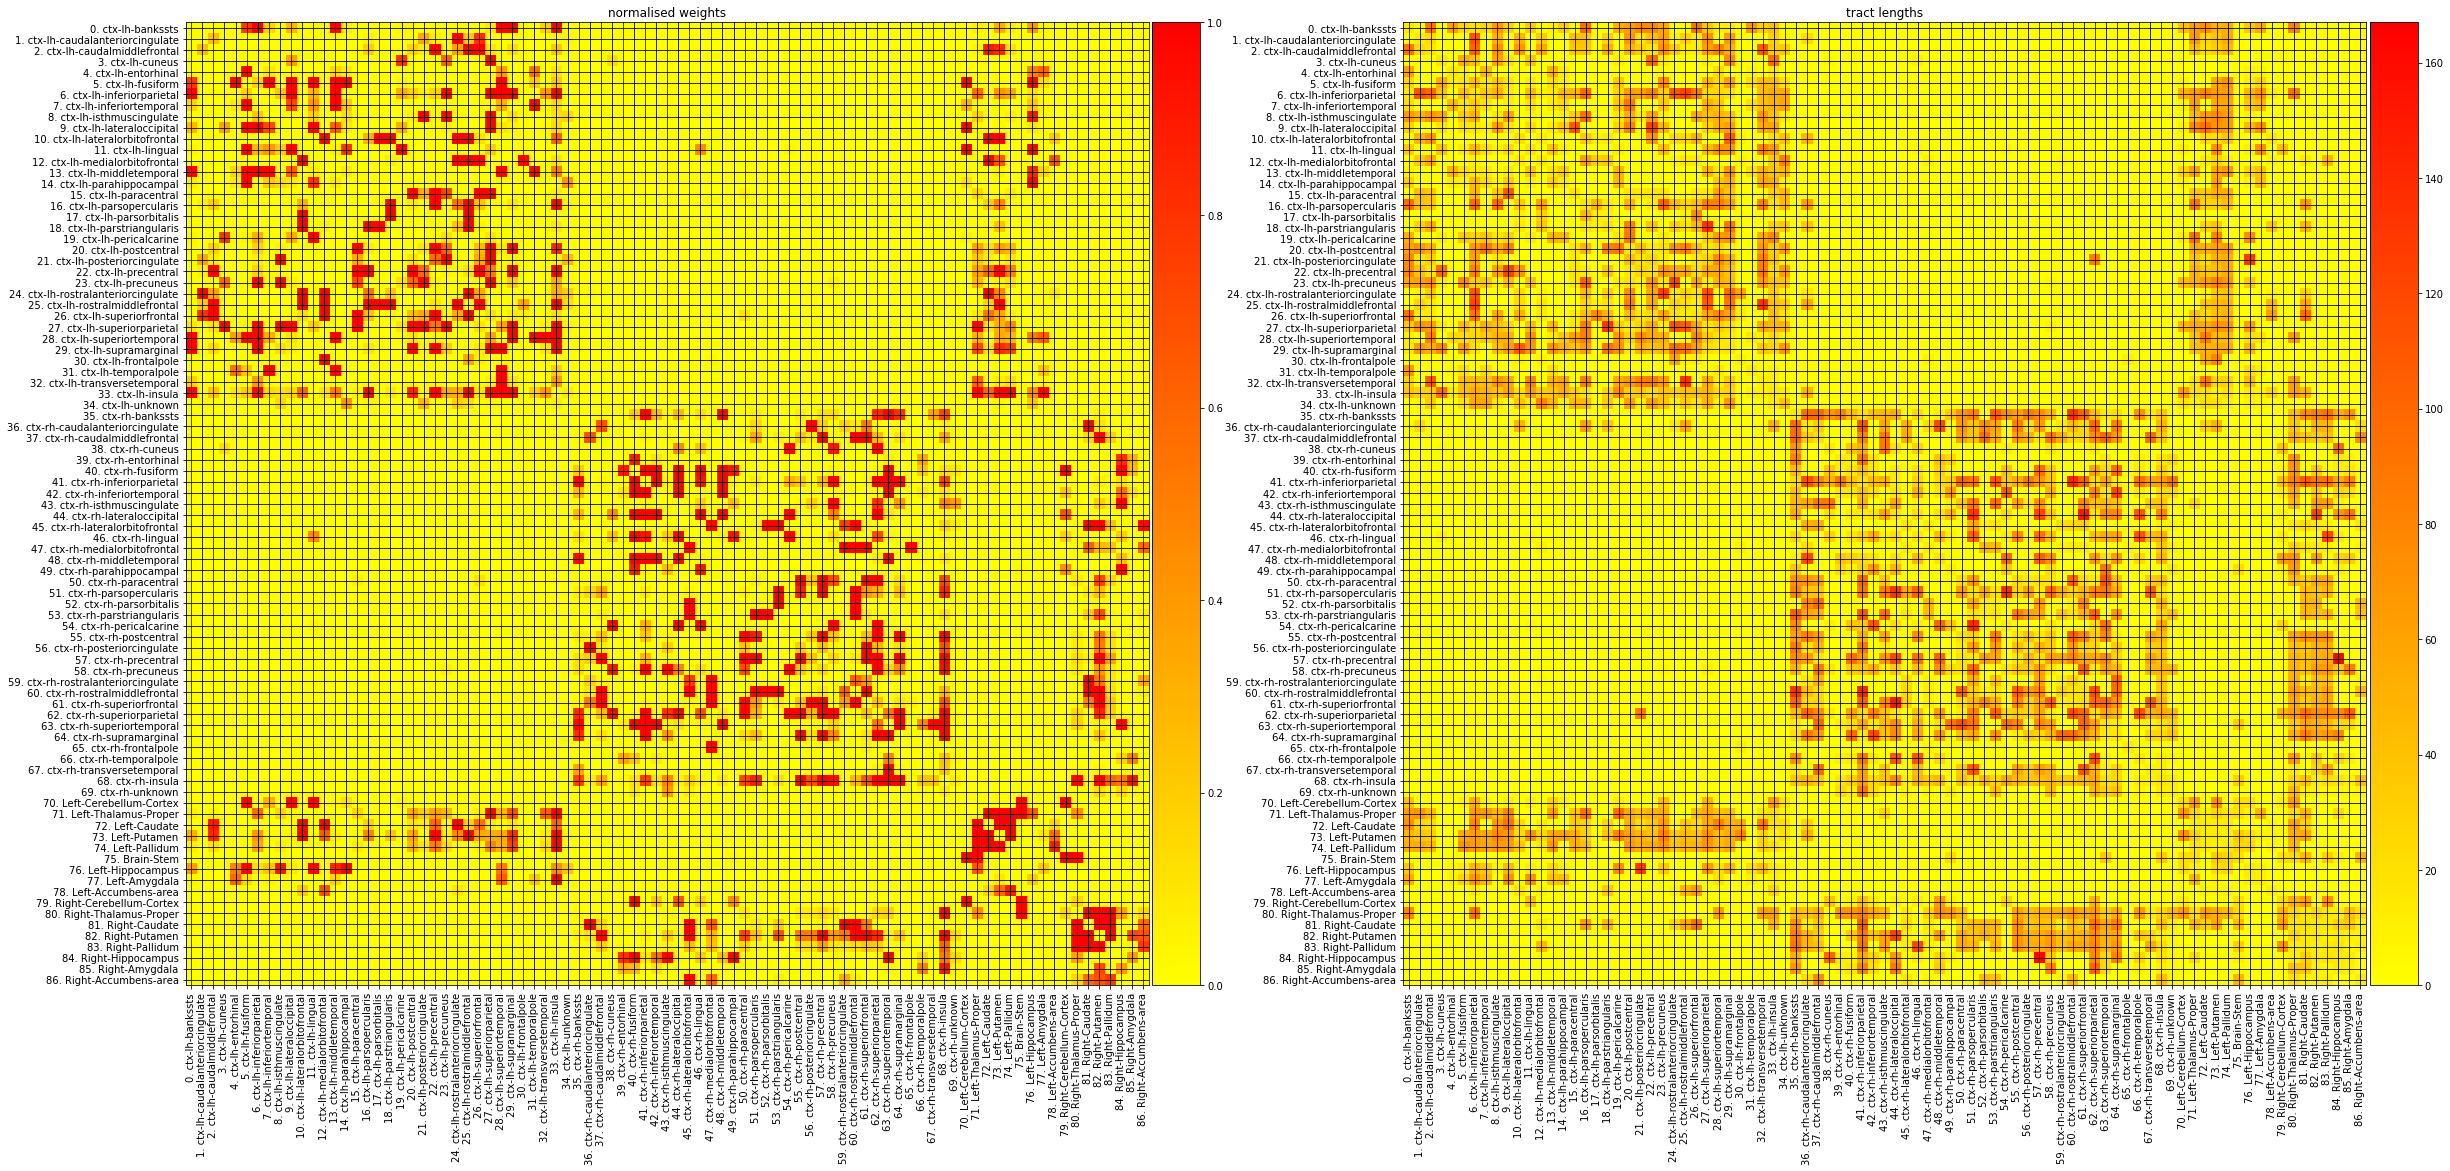

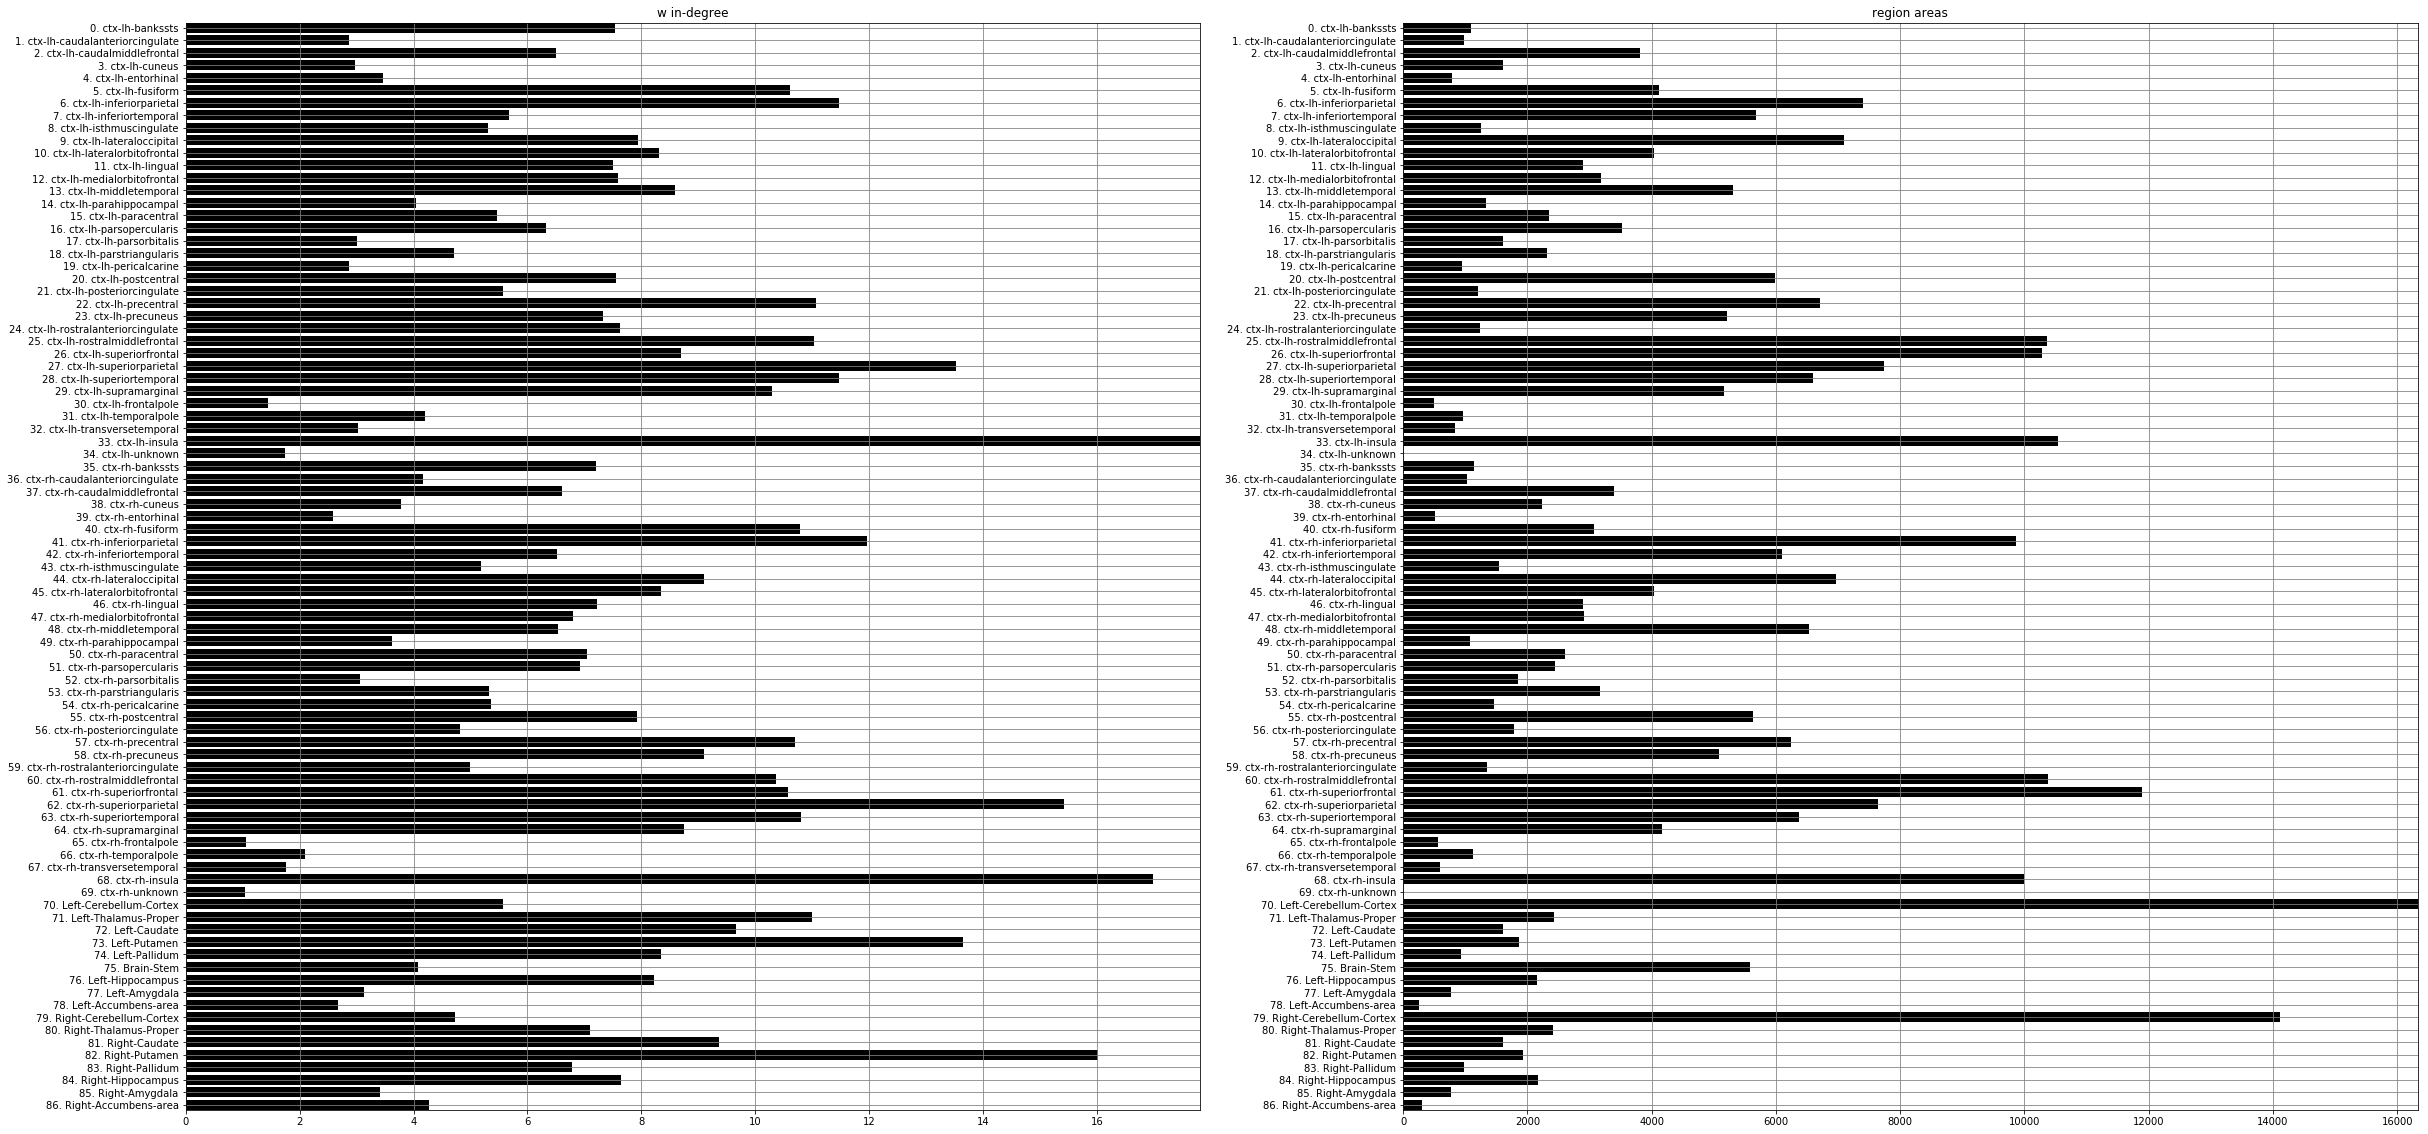

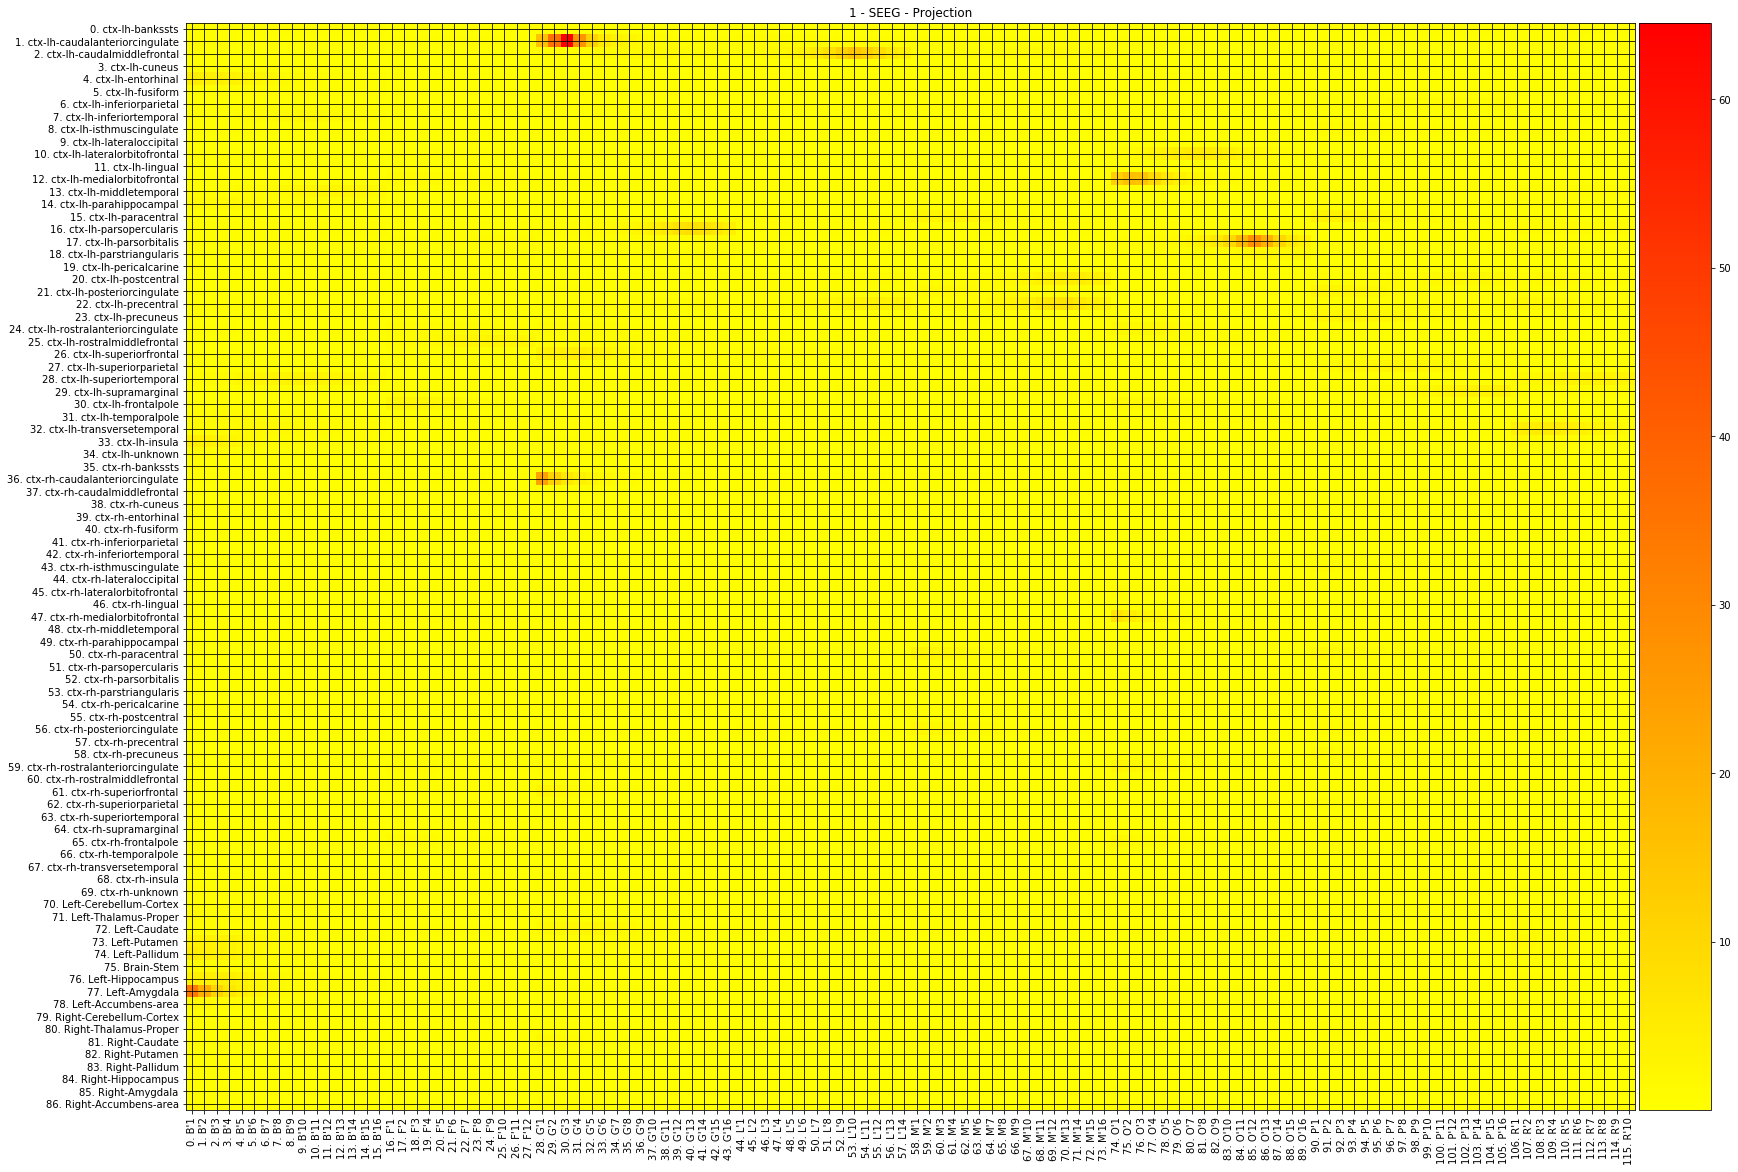

((<matplotlib.figure.Figure at 0x11b7c3dd0>,
  ((<matplotlib.axes._subplots.AxesSubplot at 0x1068c0ed0>,
    <matplotlib.axes._axes.Axes at 0x11a9609d0>),
   (<matplotlib.axes._subplots.AxesSubplot at 0x11af4e150>,
    <matplotlib.axes._axes.Axes at 0x11b724d10>))),
 (<matplotlib.figure.Figure at 0x1068b0d90>,
  (<matplotlib.axes._subplots.AxesSubplot at 0x11a960490>,
   <matplotlib.axes._subplots.AxesSubplot at 0x12042de50>)),
 (<matplotlib.figure.Figure at 0x12010cd90>,
  <matplotlib.axes._axes.Axes at 0x11f090fd0>))

In [2]:
### Reading data
logger.info("Reading from: " + config.input.HEAD)
head = reader.read_head(config.input.HEAD, seeg_sensors_files=[("seeg_xyz.txt",)])
# Plot
plotter.plot_head(head)

### Generate an hypothesis by manual definition 

In [3]:
# logger.info("\n\Reading hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(hypothesis_file)

# Formulate a VEP hypothesis manually
from tvb_fit.tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder

hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config)

# Regions of Pathological Excitability hypothesis:
x0_indices = [2, 24]
x0_values = [0.01, 0.01]
hyp_builder.set_x0_hypothesis(x0_indices, x0_values)

# Regions of Model Epileptogenicity hypothesis:
e_indices = [1, 26]
e_values = np.array([1.5, 1.25])
hyp_builder.set_e_hypothesis(e_indices, e_values)

# Regions of Connectivity hypothesis:
w_indices = [] # [(0, 1), (0, 2)] 
w_values = [] # [0.5, 2.0] 
# hypo_builder.set_w_indices(w_indices).set_w_values(w_values)

hypothesis = hyp_builder.set_normalize([0.0, 1.5]).build_hypothesis()

### ...or by reading from epileptogenicity file...

In [4]:
# from tvb_fit.tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder
## Read clinical hypothesis 
# hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.99)
# e_indices = [1, 26]# [1, 2, 25, 26]
# hypothesis = hyp_builder.build_hypothesis_from_file("clinical_hypothesis_postseeg", e_indices) 
## Change something manually if necessary
# hypothesis.x0_values = [0.01, 0.01]

### Print hypothesis

In [5]:
disease_indices = hypothesis.regions_disease_indices
disease_values = hypothesis.regions_disease_values
w_indices = hypothesis.connectivity_disease_indices
w_values = hypothesis.connectivity_disease_values
n_w = len(w_indices)
n_e = len(e_indices)
n_disease = len(disease_indices)
n_x0 = n_disease - n_e
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)
print(hypothesis)
print(hypothesis.string_regions_disease(head.connectivity.region_labels))
print(hypothesis.string_connectivity_disease(head.connectivity.region_labels))

DiseaseHypothesis{
01. Name = e_x0_Hypothesis
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 24]
05. Excitability (x0) disease values = [0.01, 0.01]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease values = [1.5, 1.25]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = []
11. Propagation strengths of indices = []}
1. ctx-lh-caudalanteriorcingulate: E=1.5
2. ctx-lh-caudalmiddlefrontal: x0=0.01
24. ctx-lh-rostralanteriorcingulate: x0=0.01
26. ctx-lh-superiorfrontal: E=1.25



### Generate model configuration from hypothesis

1: E=1.5
2: x0=0.01
24: x0=0.01
26: E=1.25
K = 3.44828
x0_max = 0.145676494639
x0_min = -2.46018609934
x1eq_max = -1.16667
x1eq_min = -1.66614
2018-09-07 19:31:39,300 - WARNING - ModelConfigPlotter - Noninteractive matplotlib backend! No highlighting functionality in plots!


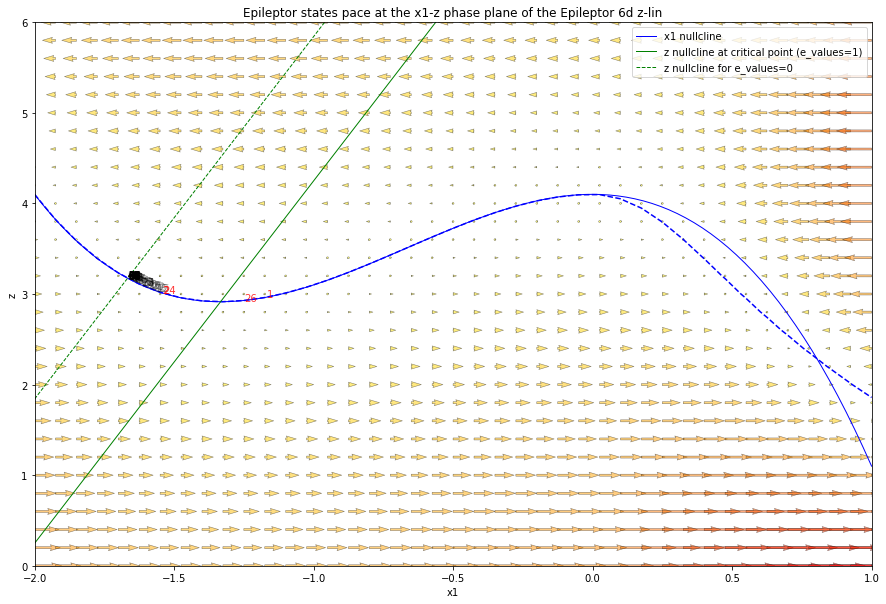

In [6]:
# logger.info("\n\nReading model configuration from file...")
# model_configuration = reader.read_model_configuration(model_config_file)

from tvb_fit.tvb_epilepsy.service.model_configuration_builder import ModelConfigurationBuilder
from tvb_fit.tvb_epilepsy.base.constants.model_constants import K_UNSCALED_DEF

logger.info("\n\nRunning hypothesis: " + hypothesis.name)
logger.info("\n\nCreating model configuration...")
# K_unscaled = 3*K_UNSCALED_DEF # in the case of the above hypothesis read from file
K_unscaled = 3*K_UNSCALED_DEF #3! in the case of the above manual hypothesis
model_config_builder = \
    ModelConfigurationBuilder("EpileptorDP", head.connectivity.normalized_weights, 
                              K_unscaled=K_unscaled)
mcs_file = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_model_config_service.h5")
writer.write_model_configuration_builder(model_config_builder, mcs_file)
print(hypothesis.string_regions_disease())
# Assume all healthy nodes have x0_values = 0.0:
model_configuration = model_config_builder.build_model_from_hypothesis(hypothesis)
# # Assume all healthy nodes have e_values = 0.0
# model_configuration = model_config_builder.build_model_from_E_hypothesis(hypothesis, head.connectivity.normalized_weights)
print "K =", np.mean(model_configuration.K)
print "x0_max =", np.max(model_configuration.x0)
print "x0_min =", np.min(model_configuration.x0)
print "x1eq_max =", np.max(model_configuration.x1eq)
print "x1eq_min =", np.min(model_configuration.x1eq)
mc_path = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ModelConfig.h5")
writer.write_model_configuration(model_configuration, mc_path)
# Plot nullclines and equilibria of model configuration
plotter.plot_state_space(model_configuration, head.connectivity.region_labels, 
                         special_idx=hypothesis.regions_disease_indices, 
                         figure_name=hypothesis.name + "_StateSpace");

# LINEAR STABILITY ANALYSIS

### Run linear stability analysis

DiseaseHypothesis{
01. Name = e_x0_Hypothesis_LSA
02. Type = Excitability_Epileptogenicity
03. Number of regions = 87
04. Excitability (x0) disease indices = [2, 24]
05. Excitability (x0) disease values = [0.01, 0.01]
06. Epileptogenicity (E) disease indices = [1, 26]
07. Epileptogenicity (E) disease values = [1.5, 1.25]
08. Connectivity (W) disease indices = []
09. Connectivity (W) disease values = []
10. Propagation indices = [ 1 26]
11. Propagation strengths of indices = [ 0.17030045  0.72901923]}


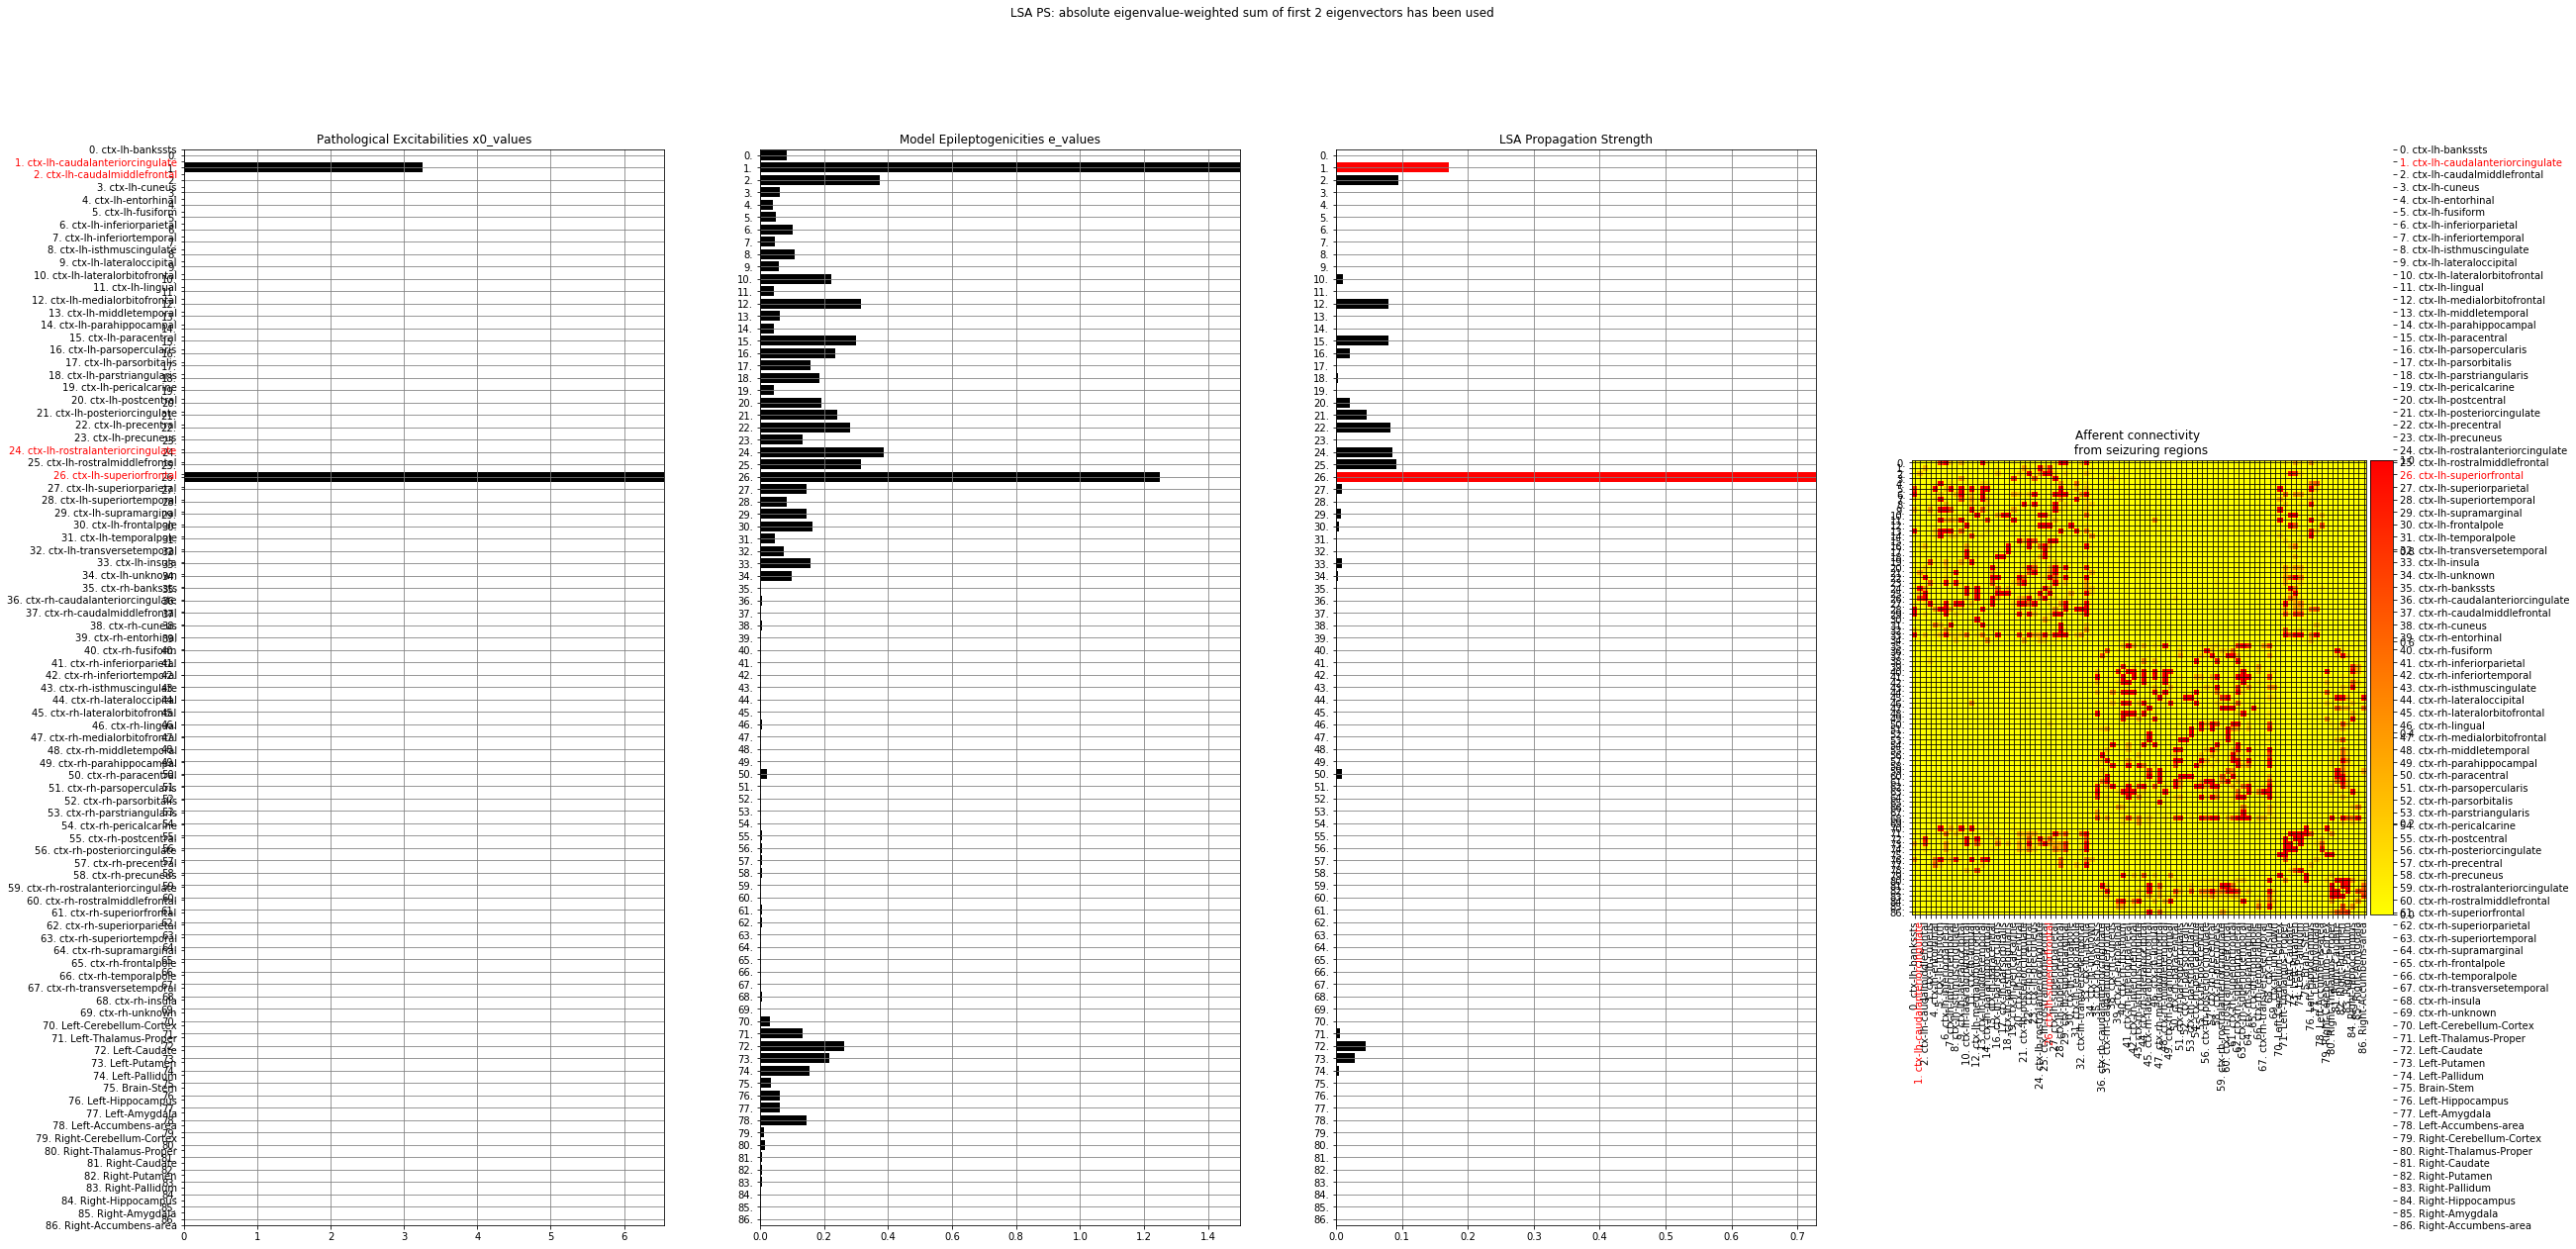

In [7]:
# Run linear stability analysis
# logger.info("\n\Reading LSA hypothesis from file...")        
# lsa_hypothesis = reader.read_hypothesis(lsa_hypothesis_file)
from tvb_fit.tvb_epilepsy.service.lsa_service import LSAService
logger.info("\n\nRunning LSA...")
# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True, 
                         normalize_propagation_strength=False)
lsa_hypothesis = lsa_service.run_lsa(hypothesis, model_configuration)
print(lsa_hypothesis)
lsa_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")
lsa_config_path = os.path.join(config.out.FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
writer.write_hypothesis(lsa_hypothesis, lsa_path)

# Plot
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, None);


### Run parameter search exploration for linear stability analysis around the clinical hypothesis

2018-09-07 19:31:53,153 - WARNING - tvb_fit.samplers.probabilistic_sampler - Input parameters' size (1) larger than the one implied by input parameters's shape (83)!
Modifying input parameters' size accordingly!

Generated a parameter search exploration for lsa/sim task,
with 88 parameters of 100 values each,
leading to 100 total execution loops

Executing loop 1 of 100

Executing loop 10 of 100

Executing loop 20 of 100

Executing loop 30 of 100

Executing loop 40 of 100

Executing loop 50 of 100

Executing loop 60 of 100

Executing loop 70 of 100

Executing loop 80 of 100

Executing loop 90 of 100

Executing loop 100 of 100


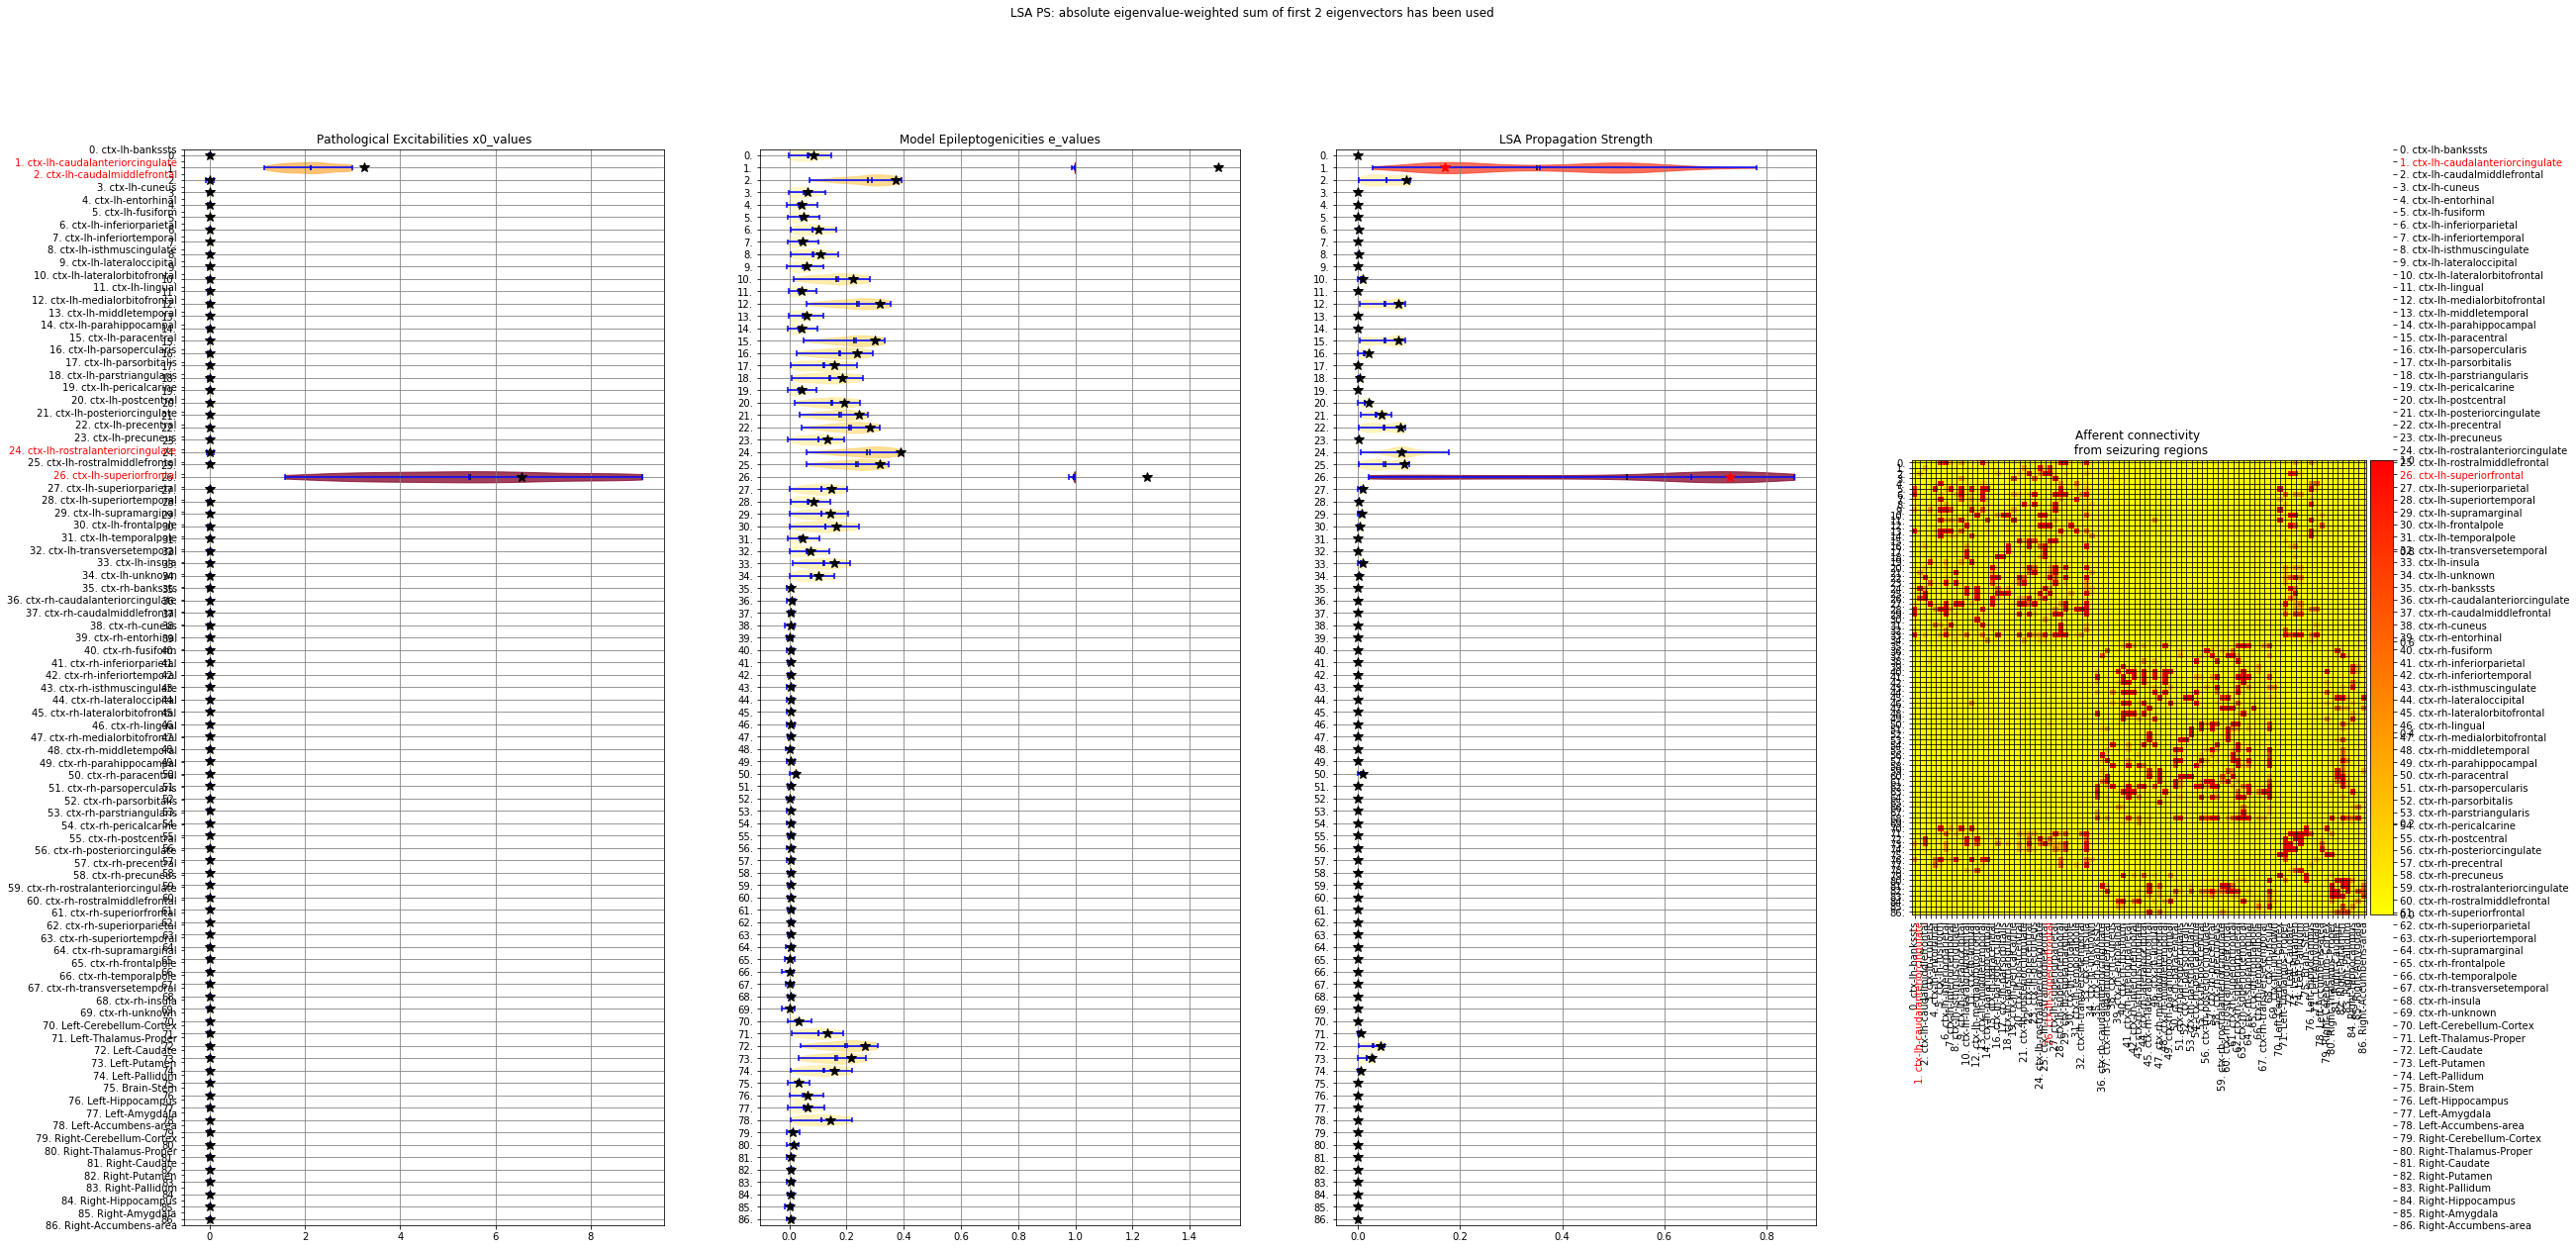

In [8]:
from tvb_fit.tvb_epilepsy.top.scripts.pse_scripts import pse_from_lsa_hypothesis
# --------------Parameter Search Exploration (PSE)-------------------------------
logger.info("\n\nRunning PSE LSA...")
n_samples = 100
pse_results = pse_from_lsa_hypothesis(n_samples, lsa_hypothesis, 
                                      head.connectivity.normalized_weights,
                                      model_config_builder, lsa_service,
                                      head.connectivity.region_labels,
                                      param_range=0.1,
                                      global_coupling=[{"indices": all_regions_indices}],
                                      healthy_regions_parameters=[
                                                        {"name": "x0_values", 
                                                         "indices": healthy_indices}],
                                      logger=logger, save_flag=False)[0]
plotter.plot_lsa(lsa_hypothesis, model_configuration, lsa_service.weighted_eigenvector_sum,
                 lsa_service.eigen_vectors_number, head.connectivity.region_labels, pse_results)

writer.write_dictionary(pse_results, os.path.join(config.out.FOLDER_RES, 
                                                  hypothesis.name + "_PSE_LSA_results.h5"))

# SIMULATION

### Prepare simulation

In [11]:
from collections import OrderedDict
from tvb_fit.tvb_epilepsy.base.model.timeseries import Timeseries, TimeseriesDimensions
from tvb_fit.tvb_epilepsy.service.simulator.simulator_builder import *
from tvb_fit.tvb_epilepsy.top.scripts.simulation_scripts import compute_seeg_and_write_ts_to_h5

# --------------------------Simulation-----------------------------------
sim_type = "fitting" # "realistic" # "tvb" # "reduced" #"fitting"
logger.info("\n\nConfiguring simulation from model_configuration...")
# If you choose model...
# Available models beyond the TVB Epileptor (they all encompass optional variations from the different papers):
# EpileptorDP: similar to the TVB Epileptor + optional variations,
# EpileptorDP2D: reduced 2D model, following Proix et all 2014 +optional variations,
# EpleptorDPrealistic: starting from the TVB Epileptor + optional variations, but:
#      -x0, Iext1, Iext2, slope and K become noisy state variables,
#      -Iext2 and |slope can be coupled to z, g, or z*g in order for spikes to appear before seizure,
#      -correlated noise is also used

# We don't want any time delays for the moment
head.connectivity.tract_lengths *= 0.0

# Use the preconfigures simulator builders...:
if sim_type == "realistic":
    sim, sim_settings = build_simulator_TVB_realistic(model_configuration, head.connectivity)
elif sim_type == "fitting":
    sim, sim_settings = build_simulator_TVB_fitting(model_configuration, head.connectivity)
elif sim_type == "reduced":
    sim, sim_settings = build_simulator_TVB_reduced(model_configuration, head.connectivity)
elif sim_type == "paper":
    sim, sim_settings = build_simulator_TVB_paper(model_configuration, head.connectivity)
else:
    sim, sim_settings = build_simulator_TVB_default(model_configuration, head.connectivity)  # "EpileptorDP" by default

# ...or if you want to do it yourself...:
                                    
# sim_builder = SimulatorBuilder(config.simulator.MODE)
# # sim_settings = reader.read_simulation_settings(sim_settings_file)
# if isequal_string(sim_type, "realistic"):
#     sim_builder = SimulatorBuilder(model_configuration).set_model("EpileptorDPrealistic"). \
#                         set_fs(2048.0).set_simulation_length(60000.0)
#     sim_builder.model_config.tau0 = 60000.0
#     sim_builder.model_config.tau1 = 0.2
#     sim_builder.model_config.slope = 0.25
#     sim_builder.model_config.pmode = np.array([PMODE_DEF])
#     sim_settings = sim_builder.build_sim_settings()
#     sim_settings.noise_type = COLORED_NOISE
#     sim_settings.noise_ntau = 20
#     # Necessary a more stable integrator:
#     sim_settings.integrator_type = "Dop853Stochastic"
# elif isequal_string(sim_type, "fitting"):
#     sim_builder = SimulatorBuilder(model_configuration).set_model("EpileptorDP2D"). \
#                         set_fs(2048.0).set_fs_monitor(2048.0).set_simulation_length(300.0)
#     sim_builder.model_config.tau0 = 30.0
#     sim_builder.model_config.tau1 = 0.5
#     sim_settings = sim_builder.build_sim_settings()
#     sim_settings.noise_intensity = np.array([0.0, 1e-5])
# elif isequal_string(sim_type, "reduced"):
#     sim_builder =  SimulatorBuilder(model_configuration).set_model("EpileptorDP2D"). \
#                         set_fs(4096.0).set_simulation_length(1000.0)
#     sim_settings = sim_builder.build_sim_settings()
# elif isequal_string(sim_type, "paper"):
#     sim_builder = SimulatorBuilder(model_configuration).set_model("Epileptor")
#     sim_settings = sim_builder.build_sim_settings()
# else:
#     sim_builder = SimulatorBuilder(model_configuration).set_model("EpileptorDP")
#     sim_settings = sim_builder.build_sim_settings()

# Integrator and initial conditions initialization.
# By default initial condition is set right on the equilibrium point.
sim, sim_settings = \
        sim_builder.build_simulator_TVB_from_model_sim_settings(head.connectivity, 
                                                                sim_settings)
    
writer.write_simulation_settings(sim.settings, os.path.join(config.out.FOLDER_RES, 
                                                            hypothesis.name + "_SimSettings.h5"))
writer.write_simulator_model(sim.model, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" + 
                                        sim.model._ui_name + "_SimModel.h5"))


### SIMULATE!

...100.09765625% done in 1.18755197525 secs2018-09-07 19:47:17,200 - WARNING - SimulationPlotter - Noninteractive matplotlib backend! No highlighting functionality in plots!
2018-09-07 19:47:17,200 - WARNING - SimulationPlotter - Noninteractive matplotlib backend! No highlighting functionality in plots!


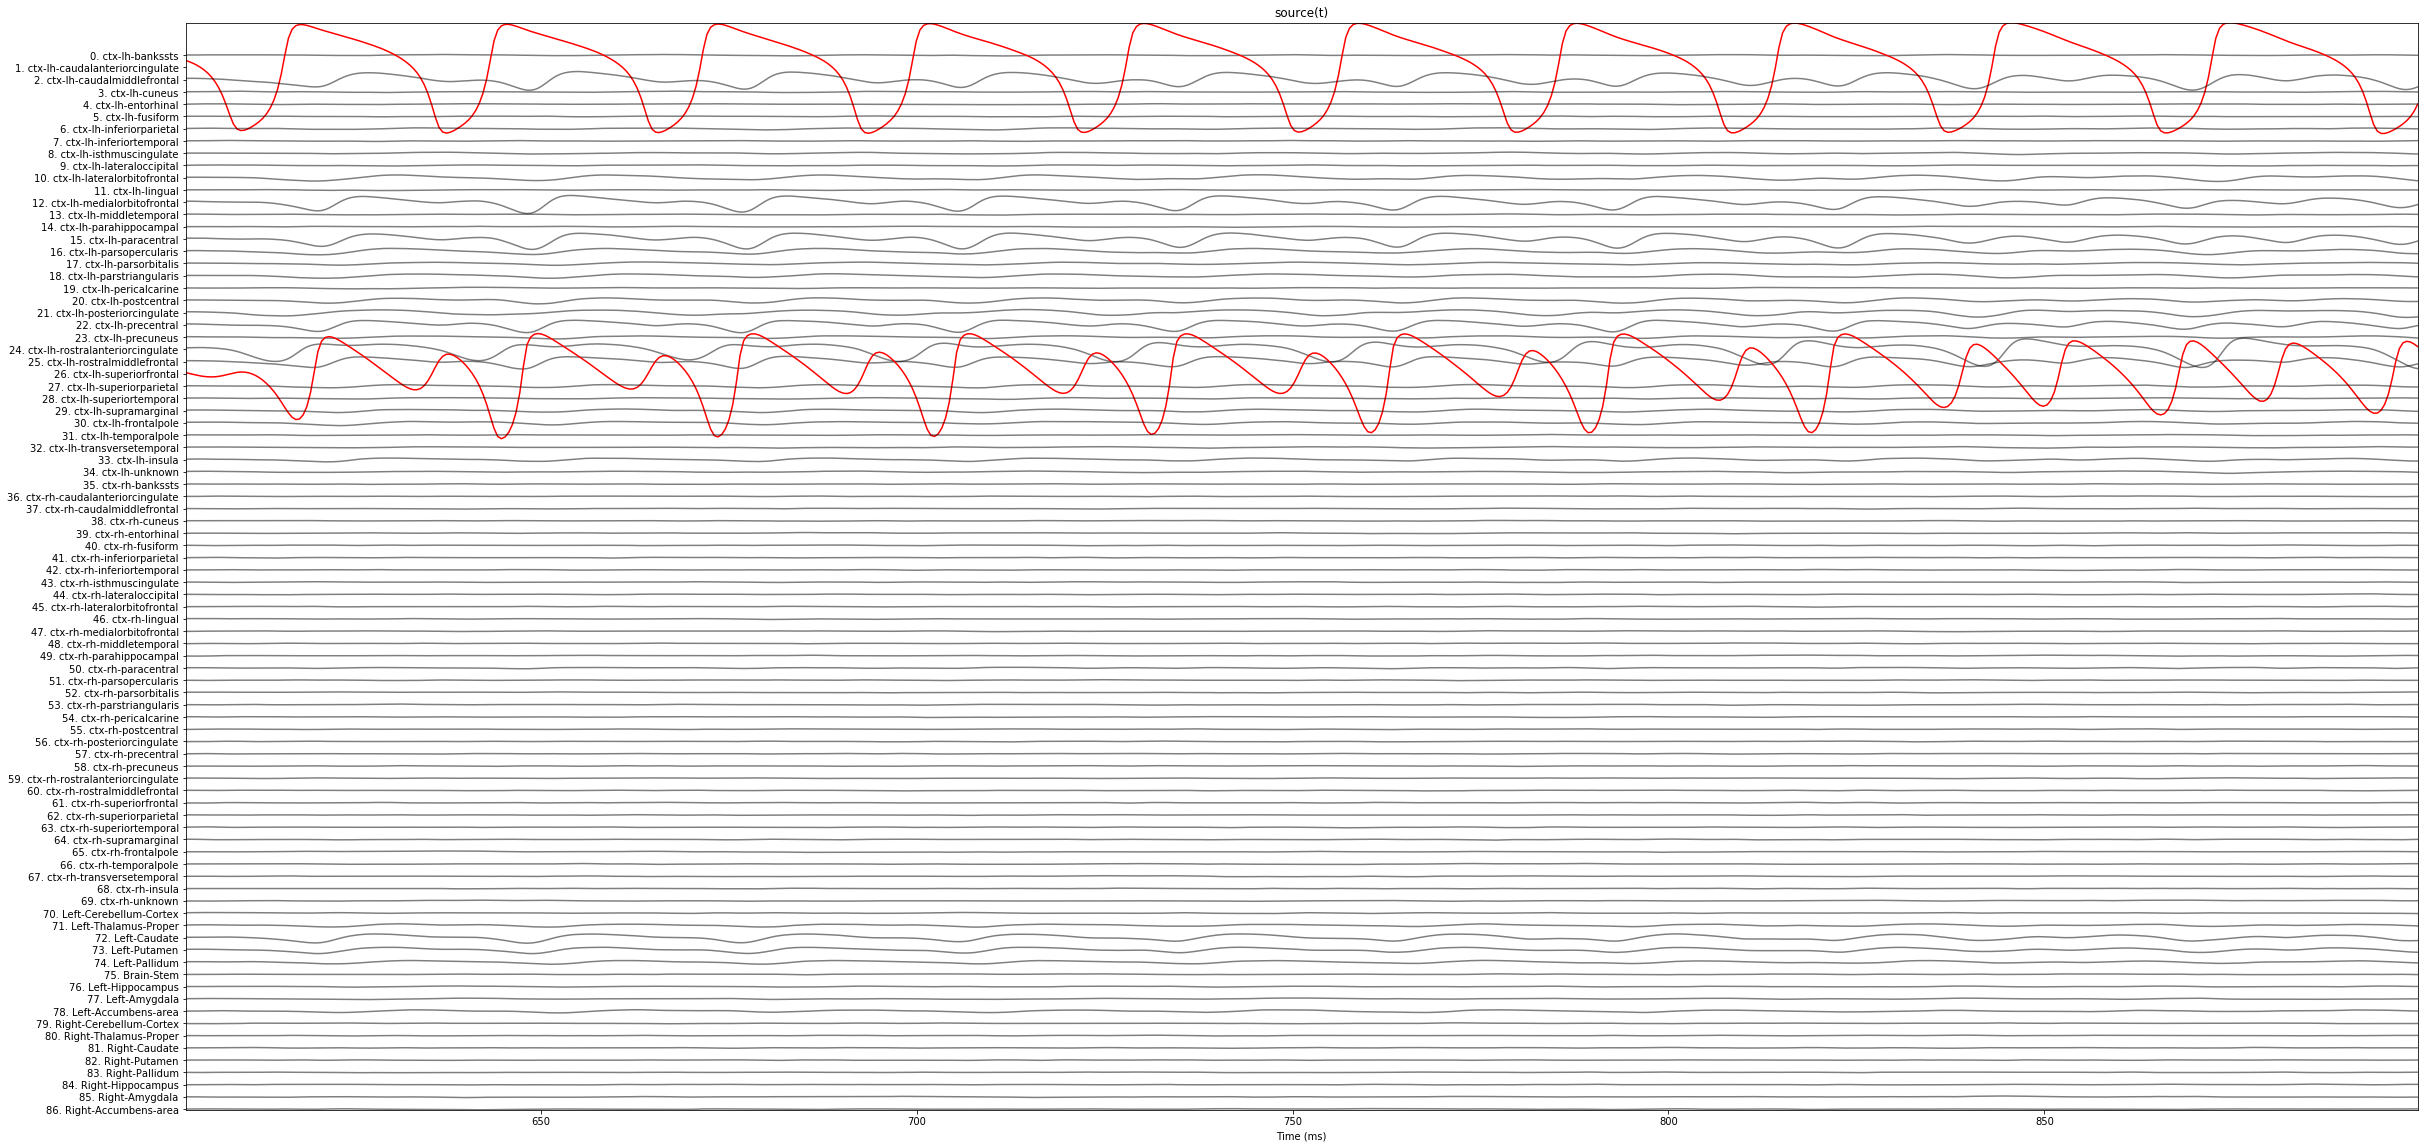

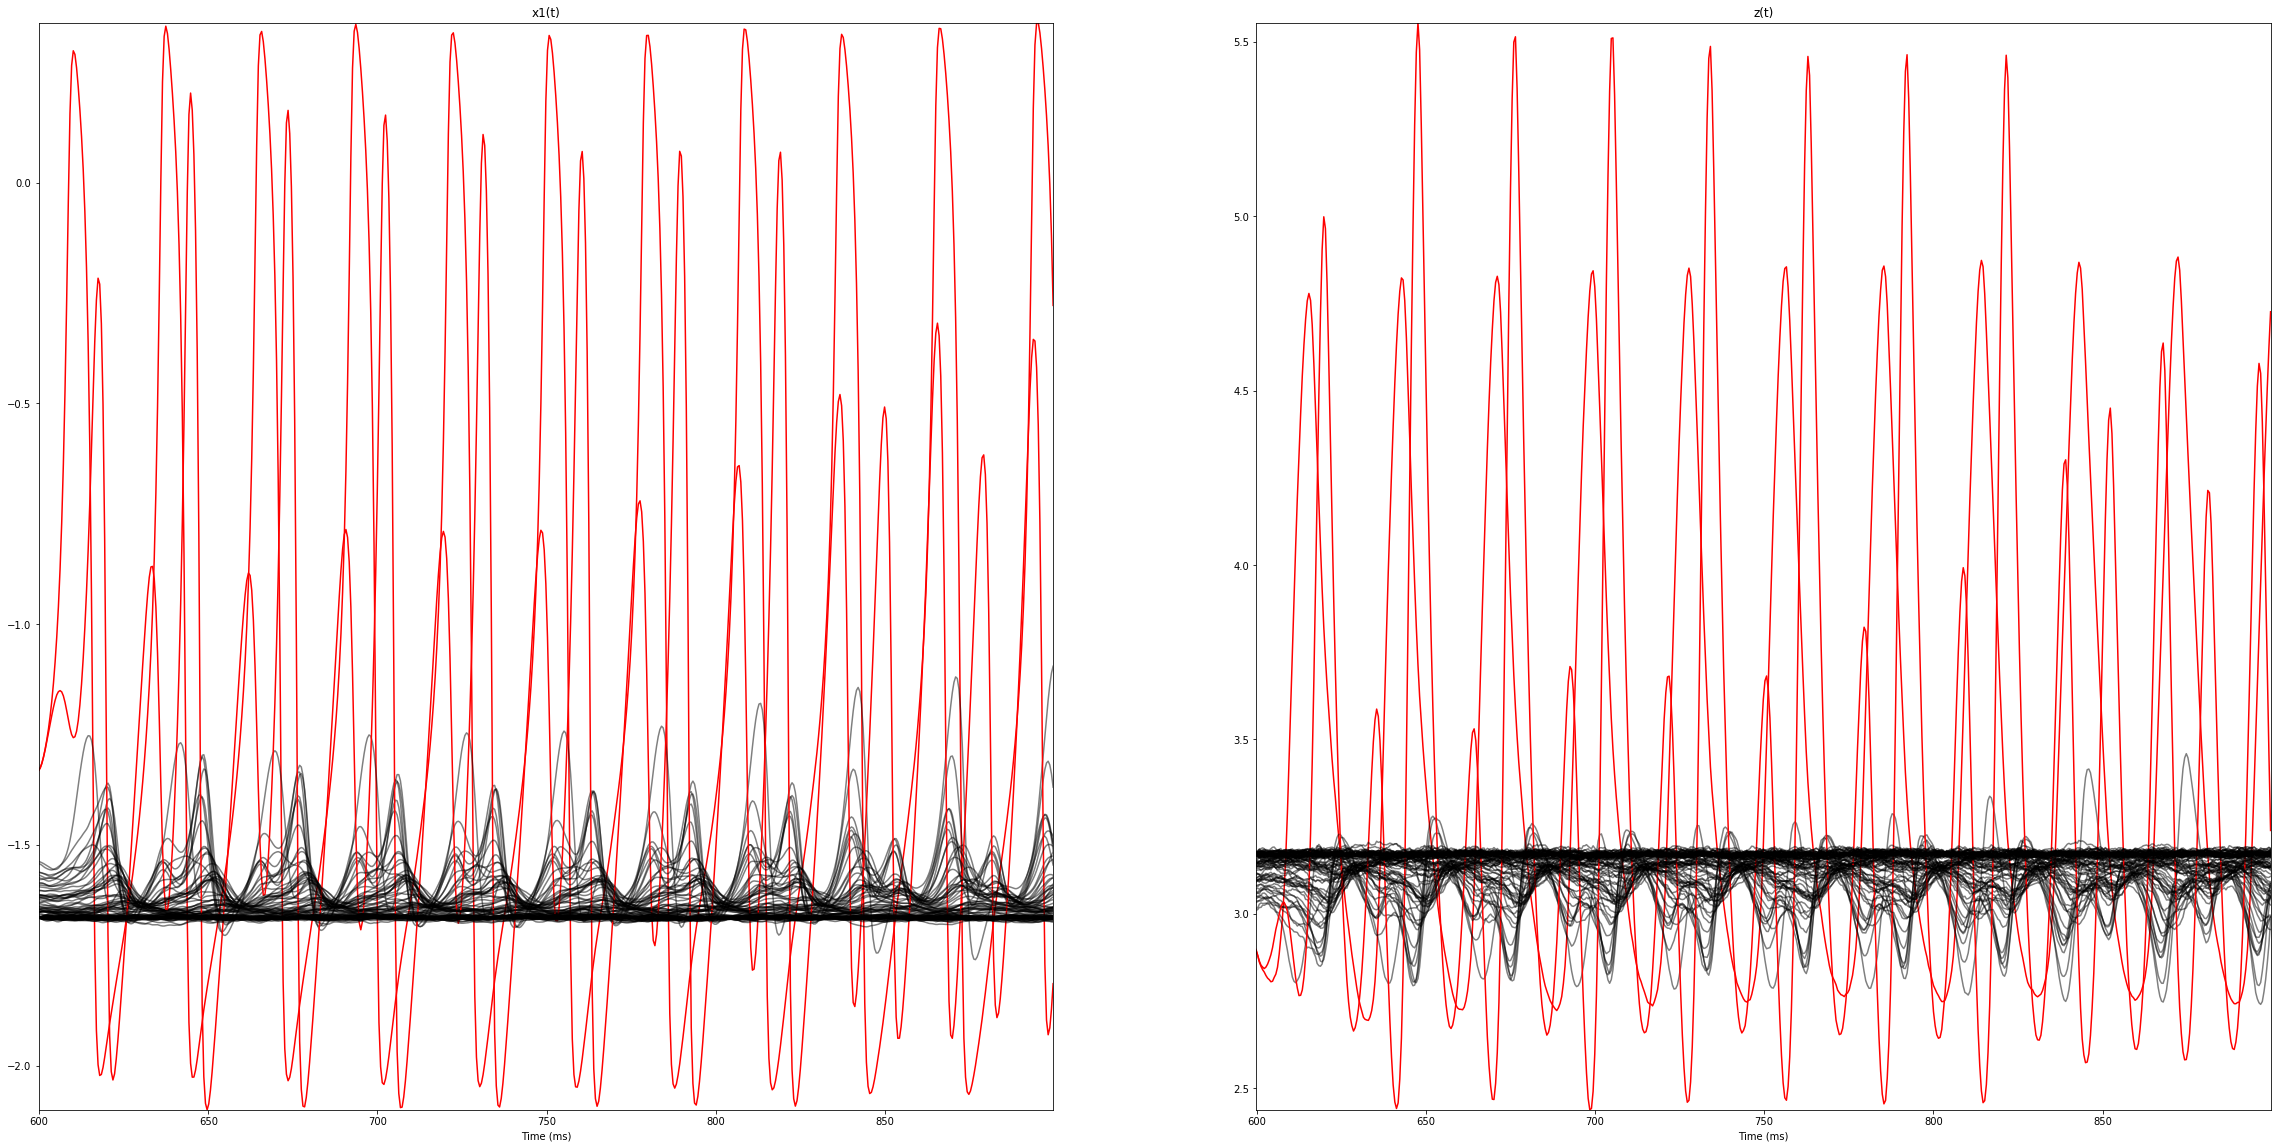

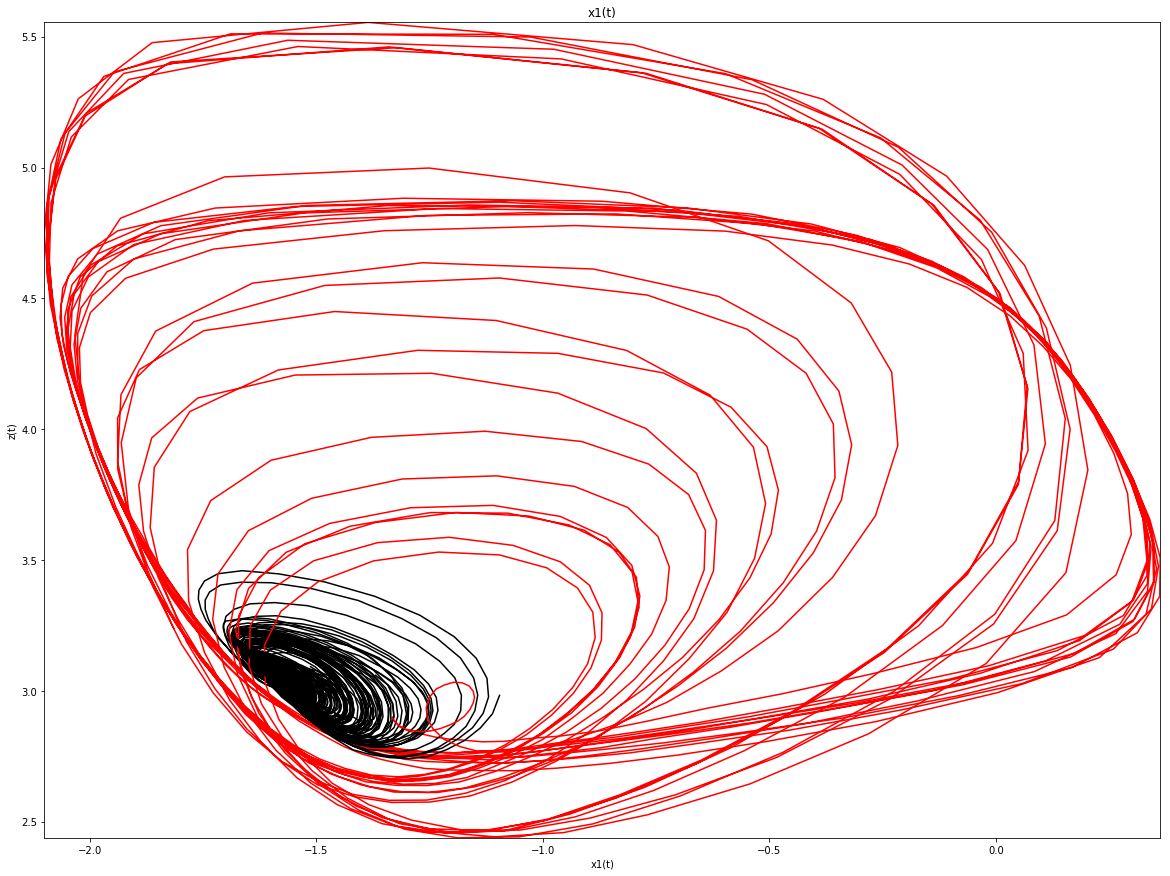

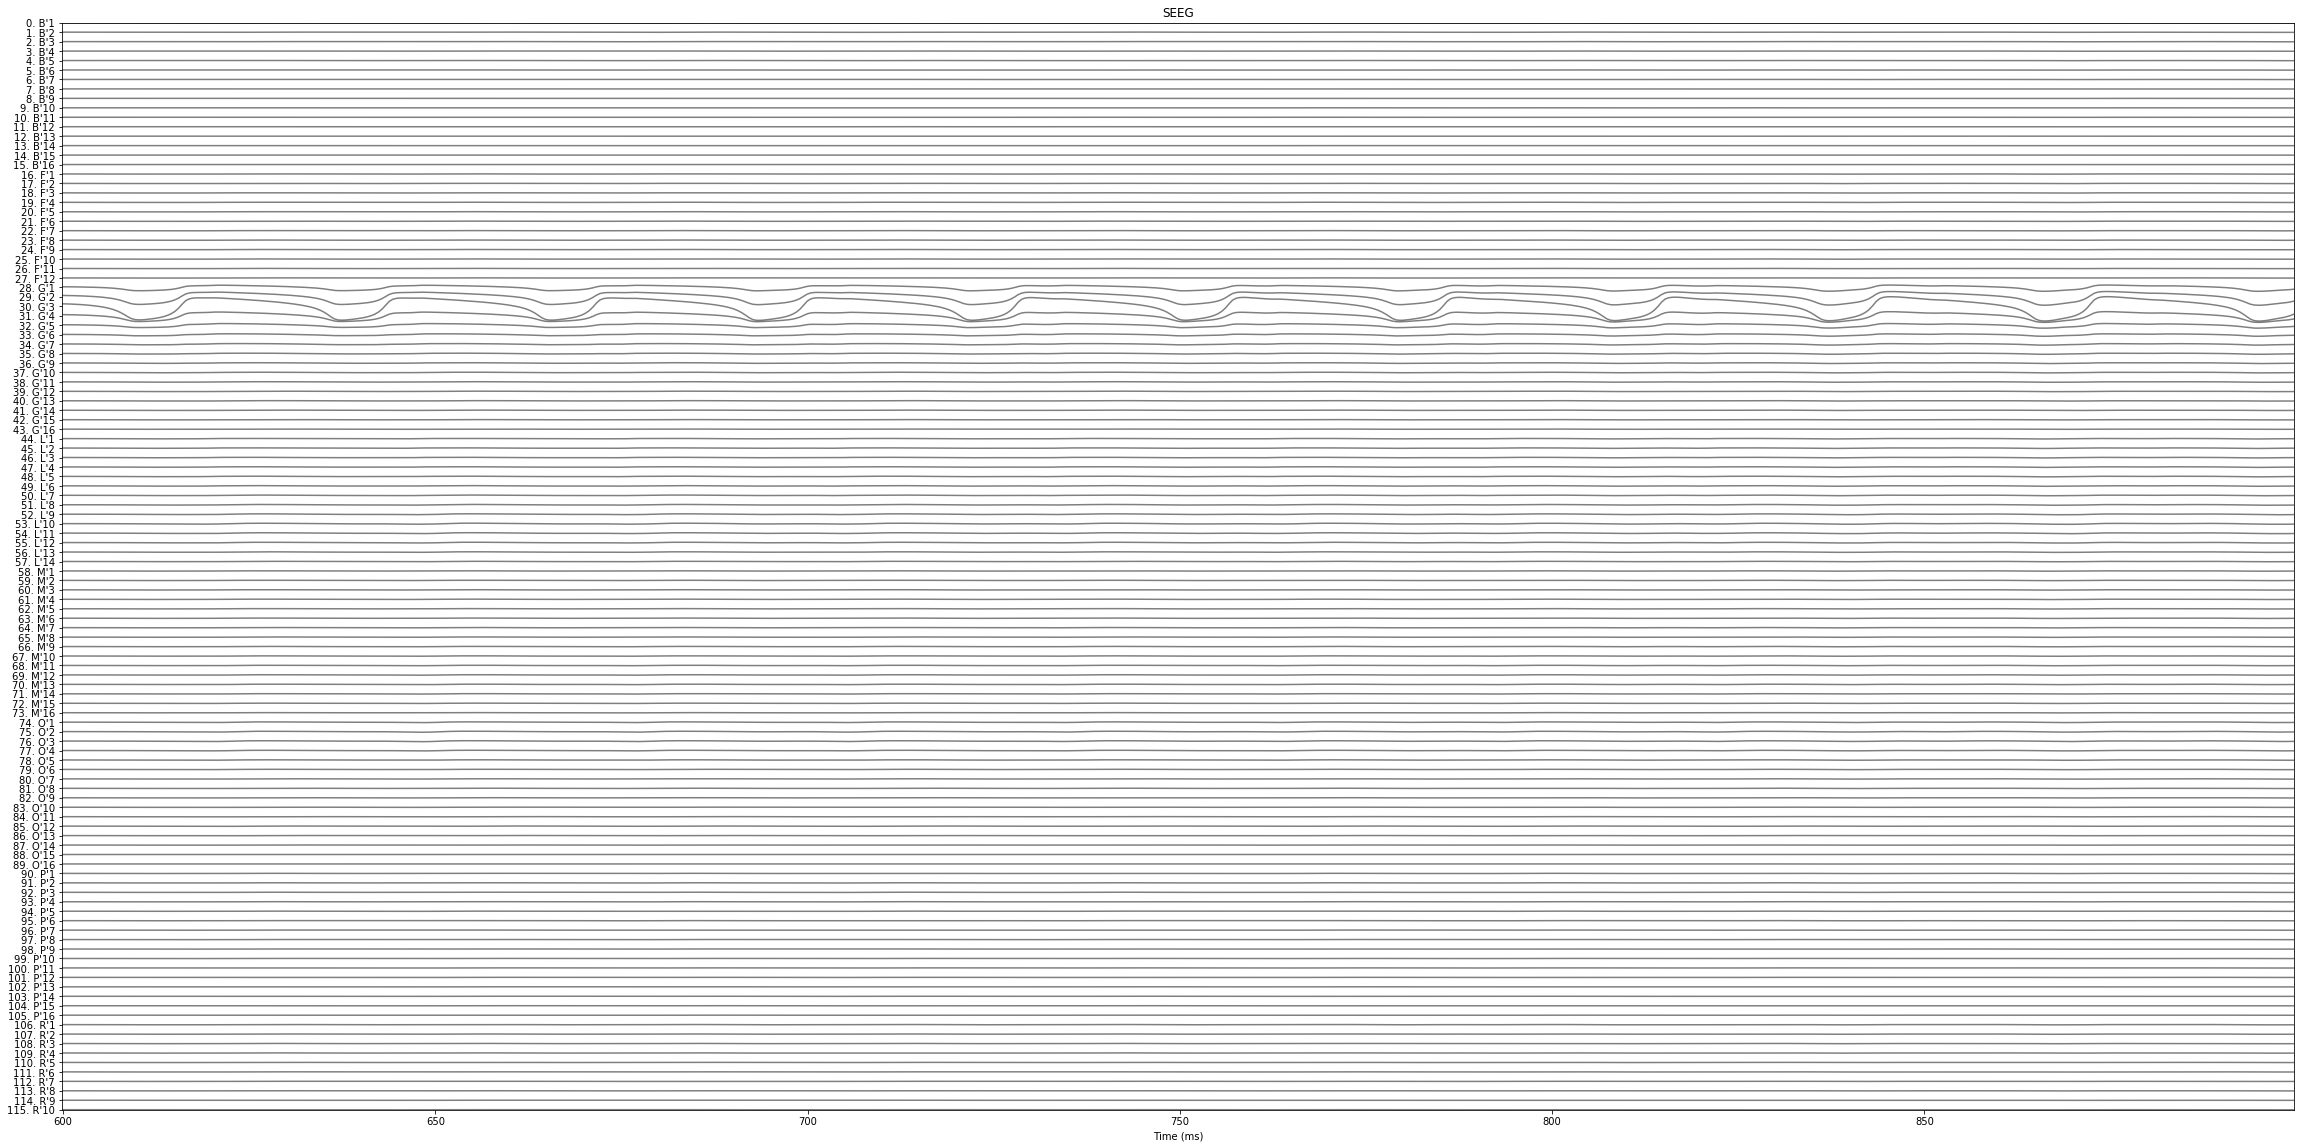

615


In [14]:
# Integrator and initial conditions initialization.
# By default initial condition is set right on the equilibrium point.
logger.info("\n\nSimulating...")
sim_output = []
seeg=[]
sim_output, status = sim.launch_simulation(report_every_n_monitor_steps=100, timeseries=Timeseries)
sim_ts_file =  os.path.join(config.out.FOLDER_RES, hypothesis.name + sim.simTVB.model._ui_name + "_ts.h5")
if not status:
    logger.warning("\nSimulation failed!")
else:
    sim_output, seeg = \
        compute_seeg_and_write_ts_to_h5(sim_output, sim.simTVB.model, head.sensorsSEEG, sim_ts_file,
                                        seeg_gain_mode="lin", hpf_flag=True, hpf_low=10.0, hpf_high=512.0)
     
    # Plot results 
    plotter.plot_simulated_timeseries(sim_output, sim.simTVB.model, lsa_hypothesis.lsa_propagation_indices, 
                                      seeg_list=seeg, spectral_raster_plot=False, title_prefix=hypothesis.name,
                                      spectral_options={"log_scale": True})
print(sim_output.time_length)

# FITTING

### Basic configurations

In [15]:
from tvb_fit.tvb_epilepsy.base.constants.model_inversion_constants import *
from tvb_fit.tvb_epilepsy.top.scripts.fitting_scripts import *

# TVB3 larger preselection of sensors:
sensors_lbls = [u"B'1", u"B'2", u"B'3", u"B'4",
                u"F'1", u"F'2", u"F'3", u"F'4", u"F'5", u"F'6", 
                    u"F'7", u"F'8", u"F'9", u"F'10", u"F'11",
                u"G'1", u"G'2", u"G'3", u"G'4", u"G'8", u"G'9", u"G'10", 
                    u"G'11", u"G'12", u"G'13", u"G'14", u"G'15",
                u"L'1", u"L'2", u"L'3", u"L'4", u"L'5", u"L'6", u"L'7",
                    u"L'8", u"L'9", u"L'10", u"L'11", u"L'12", u"L'13",
                u"M'1", u"M'2", u"M'3", u"M'7", u"M'8", u"M'9", u"M'10", 
                    u"M'11", u"M'12", u"M'13", u"M'14", u"M'15",
                u"O'1", u"O'2", u"O'3", u"O'6", u"O'7", u"O'8", u"O'9", 
                    u"O'10", u"O'11", u"O'12", # u"O'13"
                u"P'1", u"P'2", u"P'3", u"P'8", u"P'10", u"P'11", u"P'12", 
                    u"P'13", u"P'14", u"P'15", u"P'16",
                u"R'1", u"R'2", u"R'3", u"R'4", u"R'7", u"R'8", u"R'9",
         ]
sensors_inds = [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                26, 28, 29, 30, 31, 36, 37, 38, 39, 40, 41, 42,
                44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 
                58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72,
                74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 90, 91, 92, 
                97, 99, 100, 101, 102, 103, 104, 105,
                106, 107, 108, 109, 112, 113, 114]


### Generate the Probabilistic Model

In [16]:
from tvb_fit.base.constants import PriorsModes
from tvb_fit.tvb_epilepsy.service.probabilistic_models_builders import SDEProbabilisticModelBuilder
problstc_model_file = os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ProblstcModel.h5")
probabilistic_model_builder = \
     SDEProbabilisticModelBuilder(model_name="vep_sde", model_config=model_configuration,
                                  xmode=XModes.X1EQMODE.value, 
                                  priors_mode=PriorsModes.NONINFORMATIVE.value,
                                  sde_mode=SDE_MODES.NONCENTERED.value, 
                                  observation_model=OBSERVATION_MODELS.SEEG_LOGPOWER.value, 
                                  K=numpy.mean(model_configuration.K), normal_flag=False)
probabilistic_model = probabilistic_model_builder.generate_model(generate_parameters=False)
# or read one from existing file:
# probabilistic_model = reader.read_probabilistic_model(problstc_model_file)

2018-09-07 19:47:28,386 - INFO - tvb_fit.tvb_epilepsy.service.probabilistic_models_builders - Generating model by SDEProbabilisticModelBuilder...
2018-09-07 19:47:28,388 - INFO - tvb_fit.tvb_epilepsy.service.probabilistic_models_builders - SDEProbabilisticModelBuilder took 0.00217700004578 sec for model generation


### ...load or simulate prototypical for fitting time series

In [19]:
from tvb_fit.tvb_epilepsy.top.scripts.simulation_scripts import from_model_configuration_to_simulation
# --------------------- Get prototypical simulated data (simulate if necessary) ----------------------------
sim_times_on_off = [80.0, 115.0]
source_ts_file = sim_ts_file # os.path.join(config.out.FOLDER_RES, hypothesis.name + "_ts.h5")
source_ts_plotter = False
source_ts = \
    from_model_configuration_to_simulation(model_configuration, head, lsa_hypothesis,
                                           sim_type="fitting", ts_file=source_ts_file,
                                           config=config, plotter=source_ts_plotter)[0]["source"]
# source_ts = source_ts.get_time_window_by_units(sim_times_on_off[0], sim_times_on_off[1])

2018-09-07 19:49:05,231 - INFO - tvb_fit.tvb_epilepsy.top.scripts.simulation_scripts - 

Configuring simulation...
2018-09-07 19:49:05,264 - INFO - tvb_fit.tvb_epilepsy.top.scripts.simulation_scripts - 

Loading previously simulated time series from file: /Users/dionperd/Dropbox/Work/VBtech/VEP/results/notebook/test_all/res/e_x0_HypothesisEpileptorDP2D_ts.h5


In [21]:
source_ts.time_line[0]


599.853515625

### Load and preprocess simulated data

In [ ]:
from tvb_fit.base.constants import Target_Data_Type
probabilistic_model.target_data_type = Target_Data_Type.SYNTHETIC.value
times_on_off = [750.0, 1500.0] # for the default TVB "paper" simulations or  [80.0, 115.0] for fitting simulation
# This is a script that loads simulated data or simulates if file doesn't exist
# and then, performs some signal preprocessing, identical to the one for empirical data
 if observation_model == OBSERVATION_MODELS.SEEG_POWER.value:
    normalization = "baseline-100"
elif observation_model == OBSERVATION_MODELS.SOURCE_POWER.value:
    normalization = "baseline-2"
else:
    normalization = "baseline-std"
preprocessing = ["convolve"]  # for the default TVB "paper" simulations or  [] for fitting simulation
if log_flag:
    preprocessing.append("log")
preprocessing.append("decimate")
signals, simulator = \
    set_simulated_target_data(sim_ts_file, model_configuration, head, lsa_hypothesis, probabilistic_model,
                              0, sim_type="fitting", times_on_off=times_on_off, config=config,
                              # Change those for Epileptor 6D simulations:
                              bipolar=False, preprocessing=preprocessing,
                              plotter=plotter, title_prefix=hypothesis.name)

### ...or load and preprocess empirical seeg data

In [ ]:
from tvb_fit.base.constants import Target_Data_Type
probabilistic_model.target_data_type = Target_Data_Type.EMPIRICAL.value
seizure = 'SZ1_0001.edf'
# raw_empirical_file = os.path.join(config.input.RAW_DATA_FOLDER, seizure)
raw_empirical_file = os.path.join(config.input.RAW_DATA_FOLDER, seizure)
empirical_ts_file =  os.path.join(config.out.FOLDER_RES, hypothesis.name + sim.model._ui_name + "_ts_empirical.h5")
# This is a script that loads empirical data and preprocesses them from edf file
# label_strip_fun: optional argument to get labels from edf file
times_on_off = [15000.0, 30000.0]
normalization = "baseline-std"
preprocessing=["hpf", "convolve"]
log_flag = observation_model == OBSERVATION_MODELS.SEEG_LOGPOWER.value
if log_flag:
    preprocessing.append("log")
preprocessing.append("decimate")
signals = \
    set_empirical_data(raw_empirical_file, empirical_ts_file, head, sensors_lbls, 0, probabilistic_model.time_length, 
                       times_on_off=times_on_off, label_strip_fun=lambda s: s.split("POL ")[-1],
                       preprocessing=preprocessing, bipolar=False, 
                       plotter=plotter, title_prefix=hypothesis.name)

### Generate Model Inversion Service and select active regions

In [ ]:
from tvb_fit.tvb_epilepsy.service.model_inversion_services import SDEModelInversionService
model_inversion = SDEModelInversionService()
# Exclude ctx-l/rh-unknown regions from fitting
model_inversion.active_regions_exlude = find_labels_inds(head.connectivity.region_labels, ["unknown"])
# Update active model's active region nodes
e_values = pse_results.get("e_values_mean", model_configuration.e_values)
lsa_propagation_strengths = pse_results.get("lsa_propagation_strengths_mean", lsa_hypothesis.lsa_propagation_strengths)
model_inversion.active_e_th = 0.2 # 0.1 or 0.05 for including more regions
probabilistic_model = \
    model_inversion.update_active_regions(probabilistic_model, e_values=e_values,
                                          lsa_propagation_strengths=lsa_propagation_strengths, reset=True)
# print(probabilistic_model)

### Select target data for fitting

In [ ]:
model_inversion.decim_ratio = 2
model_inversion.cut_target_times_on_off = times_on_off
model_inversion.normalization = normalization
if probabilistic_model.observation_model in OBSERVATION_MODELS.SEEG.value:
    model_inversion.auto_selection = "rois-power"
    model_inversion.sensors_per_electrode = 2
target_data, probabilistic_model, gain_matrix = \
    model_inversion.set_target_data_and_time(signals, probabilistic_model, 
                                             head=head, sensors=head.get_sensors_id(sensor_ids=0))

### Generate model parameters

In [ ]:
probabilistic_model.time_length = target_data.time_length
probabilistic_model.upsample = compute_upsample(probabilistic_model.time_length,
                                                SEIZURE_LENGTH, probabilistic_model.tau0)
probabilistic_model.parameters.update(
                SDEProbabilisticModelBuilder(probabilistic_model, normal_flag=False). \
                    generate_parameters([XModes.X1EQMODE.value, "sigma_"+ XModes.X1EQMODE.value,
                                         "tau1", "x1_init", "z_init", # "tau0","K", "sigma_init", "sigma_eq", "x1"
                                         "sigma", "dZt", "epsilon", "scale", "offset"], # "dX1t",
                                        target_data, source_ts, gain_matrix))

### Plot (and write to file) probabilistic model and target data

In [ ]:
plotter.plot_probabilistic_model(probabilistic_model, hypothesis.name + " Probabilistic Model")
plotter.plot_raster({'Target Signals': target_data.squeezed}, target_data.time_line,
                    time_units=target_data.time_unit, title=hypothesis.name + ' Target Signals raster',
                    offset=0.1, labels=target_data.space_labels)
plotter.plot_timeseries({'Target Signals': target_data.squeezed}, target_data.time_line,
                        time_units=target_data.time_unit, title=hypothesis.name + ' Target Signals', 
                        labels=target_data.space_labels)

writer.write_probabilistic_model(probabilistic_model, model_configuration.number_of_regions, problstc_model_file)
writer.write_timeseries(target_data, os.path.join(config.out.FOLDER_RES, hypothesis.name + 
                                                  sim.model._ui_name + "_FitTargetData.h5"))
print(probabilistic_model)

### Generate stan model data (.R) 

In [ ]:
from tvb_fit.tvb_epilepsy.service.vep_stan_dict_builder import build_stan_model_data_dict
# ...or in order to interface with INS models:
# from tvb_epilepsy.service.model_inversion.vep_stan_dict_builder import \
#     build_stan_model_data_dict_to_interface_ins as build_stan_model_data_dict
model_data = build_stan_model_data_dict(probabilistic_model, target_data.squeezed,
                                        model_configuration.connectivity, gain_matrix,
                                        time=target_data.time_line)

# writer.write_dictionary(model_data, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" 
#                                                  + probabilistic_model.name + "_ModelData.h5"))

## FIT!

### Initialize stan model file and service

In [ ]:
from tvb_fit.samplers.stan.cmdstan_interface import CmdStanInterface

stan_model_name = "vep_sde"
stan_interface = CmdStanInterface(model_name=stan_model_name,
                                  model_code_path=os.path.join(config.generic.PROBLSTC_MODELS_PATH, 
                                                               stan_model_name + ".stan"), 
                                  fitmethod="sample", config=config)

stan_interface.set_or_compile_model()

### Fit (sample with HMC or ADVI, or optimize)

In [ ]:
n_chains_or_runs = 2 # default: 4
output_samples = 30 # default: max(int(np.round(1000.0 / n_chains_or_runs)), 500)
# Sampling (HMC)
num_samples = output_samples
num_warmup = 30 # default: 1000
max_depth = 8 # default: 12
delta = 0.8 # default: 0.9
# ADVI or optimization:
iter = 1000000 # default: 1000000
tol_rel_obj = 1e-6
if stan_interface.fitmethod.find("sampl") >= 0: 
    skip_samples = num_warmup
else:
    skip_samples = 0
    
kwargs = {}
estimates, samples, summary = stan_interface.fit(debug=0, simulate=0, model_data=model_data, refresh=1, 
                                                 n_chains_or_runs=n_chains_or_runs,
                                                 iter=iter, tol_rel_obj=tol_rel_obj,
                                                 num_warmup=num_warmup, num_samples=num_samples,
                                                 max_depth=max_depth, delta=delta,
                                                 save_warmup=1, plot_warmup=1, **kwargs)



### Get, convert, write to file and plot fitting results...

In [ ]:
# For loading results at a different time from fitting:
if "estimates" not in locals().keys():
    estimates, samples, summary = stan_interface.read_output()
    if fitmethod.find("sampl") >= 0:
        plotter.plot_HMC(samples, figure_name=hypothesis.name + ": " +
                         probabilistic_model.name + " HMC NUTS trace")
        
# Writing results in .h5 files
for obj, filename, in zip([estimates, samples], ["_FitEst.h5", "_FitSamples.h5"]):
    writer.write_list_of_dictionaries(obj, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" 
                                           + probabilistic_model.name + filename))
writer.write_dictionary(summary, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" 
                                              + probabilistic_model.name + "_FitSummary.h5"))

Rhat = stan_interface.get_Rhat(summary)
# Interface backwards with INS stan models
# from tvb_epilepsy.service.model_inversion.vep_stan_dict_builder import convert_params_names_from_ins
# estimates, samples, Rhat, model_data = \
#     convert_params_names_from_ins([estimates, samples, Rhat, model_data])  
if stan_interface.fitmethod.find("opt") < 0:
    stats = {"Rhat": Rhat}
else:
    stats = None
    if fitmethod.find("sampl") >= 0:
        plotter.plot_HMC(samples, figure_name=hypothesis.name + ": " +
                         probabilistic_model.name + " HMC NUTS trace")
    
# Information criteria:
# scale_signal, offset_signal, time_scale, epsilon, sigma -> 5 (+ K = 6)
# x0[active] -> probabilistic_model.model.number_of_active_regions
# x1init[active], zinit[active] -> 2 * probabilistic_model.number_of_active_regions
# dZt[active, t] -> probabilistic_model.number_of_active_regions * (probabilistic_model.time_length-1)
number_of_total_params =  \
        5 + probabilistic_model.number_of_active_regions * (3 + (probabilistic_model.time_length-1))
info_crit = \
    stan_interface.compute_information_criteria(samples, number_of_total_params, skip_samples=skip_samples,
                                             # parameters=["amplitude_star", "offset_star", "epsilon_star", 
                                             #             "sigma_star", "time_scale_star", "x0_star", #  "k_star",
                                             #             "x_init_star", "z_init_star", "z_eta_star"], # "x_eta" 
                                               merge_chains_or_runs_flag=False)
writer.write_dictionary(info_crit, os.path.join(config.out.FOLDER_RES, hypothesis.name + "_" +
                                                probabilistic_model.name + "InfoCrit.h5"))

if "x1eq" in probabilistic_model.parameters.keys():
    region_violin_params = ["x0", "x1eq", "x1_init", "zeq", "z_init"]
else:
    region_violin_params = ["x0", "x1_init", "z_init"]
plotter.plot_fit_results(estimates, samples, model_data, target_data, probabilistic_model, 
                         info_crit, stats=stats,
                         pair_plot_params=["tau1", "tau0", "K", "sigma", "epsilon", "scale", "offset"],  
                         region_violin_params=region_violin_params, 
                         regions_labels=head.connectivity.region_labels, skip_samples=num_warmup, 
                         title_prefix=hypothesis.name + "_" + probabilistic_model.name)

### Generate a new model configuration from each one of the chains' results

In [ ]:
for id_est, est in enumerate(ensure_list(estimates)):
    K = est.get("K", np.mean(model_configuration.K))
    tau1 = est.get("tau1", np.mean(model_configuration.tau1))
    tau0 = est.get("tau0", np.mean(model_configuration.tau0))
    fit_model_configuration_builder = \
        ModelConfigurationBuilder(model_configuration.model_name, model_configuration.connectivity
                                  K_unscaled=K* hypothesis.number_of_regions)
    x0 = model_configuration.x0
    x0[probabilistic_model.active_regions] = est["x0"]
    x0_values_fit = fit_model_configuration_builder._compute_x0_values_from_x0_model(x0)
    hyp_fit = HypothesisBuilder().\
                  set_nr_of_regions(head.connectivity.number_of_regions).\
                      set_name('fit' + str(id_est + 1) + "_" + hypothesis.name).\
                          set_x0_hypothesis(list(probabilistic_model.active_regions),
                                            x0_values_fit[probabilistic_model.active_regions]).\
                              build_hypothesis()
    writer.write_hypothesis(hyp_fit, os.path.join(config.out.FOLDER_RES, hyp_fit.name + ".h5"))
    model_configuration_fit = \
        fit_model_configuration_builder.build_model_from_hypothesis(hyp_fit)
    writer.write_model_configuration(model_configuration_fit, os.path.join(config.out.FOLDER_RES, 
                                                                           hyp_fit.name + "_FitModelConfig.h5"))

    # Plot nullclines and equilibria of fit model configuration
    plotter.plot_state_space(model_configuration_fit, region_labels=head.connectivity.region_labels,
                             special_idx=probabilistic_model.active_regions,
                             figure_name=hyp_fit.name + "_Nullclines and equilibria")